In [1]:
%cd '/home/vri/Projects/research/Flood-detection'

/home/vri/Projects/research/Flood-detection


In [2]:
import os
import json
import glob
import pandas as pd
import matplotlib.pyplot as plt
import tarfile
import numpy as np 

import subprocess
from subprocess import PIPE

import rasterio
import cv2
from rasterio.plot import show

import torch
import torchvision
from torch import nn , utils, Tensor
from torchvision import transforms as T
import torch.utils.data as data
import torchvision.utils as vutils
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models
import pytorch_lightning as pl
from pytorch_lightning import callbacks
from pytorch_lightning.loggers import TensorBoardLogger
import torch.optim as optim

from utils import utils_dirs

In [3]:
torch.backends.cudnn.benchmark = True
torch.set_float32_matmul_precision('medium')

In [4]:
band_list = ['B02.tif' , 'B03.tif' , 'B04.tif' , 'B08.tif']
ROOT_DIR = '/home/vri/Projects/research/Flood-detection/data/transformer_data/sen12floods_s2_source'
LABEL_PATH = './data/transformer_labels/sen12floods_s2_labels'

In [5]:
actual_flist = utils_dirs.get_img_folders(flag='valid', root_path = ROOT_DIR)

The number of valid image subfolders are: 1949


In [6]:
def get_image_labels(dirname, label_dir):
    """function to get image label for corresponding image dir

    Args:
        dirname (str): name of image subdirectory
        label_dir (path.path): path to label directory
    """
    pd = dirname.split("_")
    pd = f"{pd[0]}_{pd[1]}_labels_{pd[3]}_{pd[4]}_{pd[5]}_{pd[6]}"

    json_data = open (f"{label_dir}/{pd}/stac.json", "rb")
    jdata = json.load(json_data)
    flood = jdata["properties"]["FLOODING"]

    image_label = 1 if flood else 0

    return image_label


In [7]:
class CustomDataset(Dataset):

    def __init__(self, img_list, label_path, transform = None ):
        self.transform = transform
        self.img_list = img_list
        self.label_path = label_path
        

    def __getitem__(self, idx):
        img_name = utils_dirs.get_dirname(self.img_list[idx])
        label = get_image_labels(img_name, self.label_path)

        img = cv2.imread(f"{self.img_list[idx]}/stack.tif")
        if self.transform:
            img = self.transform(img)
            # label = self.transform(label)
        
        return img,label
    
    def __len__(self):
        return len(self.img_list)

In [8]:
BATCH_SIZE = 16
MEAN, STD=(0.485, 0.456, 0.406), (0.229, 0.224, 0.225)

In [10]:
data_transforms = T.Compose([
    
    T.ToTensor() ,
    T.Resize((224, 224), antialias=True),
    T.Normalize(MEAN, STD)
])

#         transforms.Resize((224, 224)),
    #         transforms.ToTensor(),
    #         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [11]:
total_dataset = CustomDataset(actual_flist, LABEL_PATH, data_transforms)

test_size = int(0.15 * len(total_dataset))

train_size = int(0.8*(len(total_dataset) - test_size))
val_size = len(total_dataset)- test_size - train_size

train_set , test_set, val_set = random_split(total_dataset, [train_size, test_size, val_size])

print(f"Images in train set: {len(train_set)}")
print(f"Images in test set: {len(test_set)}")
print(f"Images in val set: {len(val_set)}")

Images in train set: 1325
Images in test set: 292
Images in val set: 332


In [12]:
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=16)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, num_workers=16)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, num_workers=16)

In [13]:
def plot_images(dataloader, num_images=16):
    """
    function for easy visualisation of images from dataset.
    args:
        dataloader: a pytorch dataloader object
        num_images: number of images to be plotted
    """
    
    # Get a batch of images from the dataloader
    data = next(iter(dataloader))
    images, _ = data
    images = [img[[2,1,0],:,:] for img in images]

    # sent_img[[2,1,0], :, :]/np.amax(sent_img)
        

    # Generate a grid of images
    img_grid = vutils.make_grid(images[:num_images], nrow=4, padding=2, normalize=True)

    # Convert the image grid to a numpy array and transpose the dimensions
    img_grid = np.transpose(img_grid.cpu().numpy(), (1, 2, 0))

    # Plot the image grid
    plt.figure(figsize=(10,10))
    plt.axis("off")
    plt.imshow(img_grid)
    plt.title("Sample Images")
    plt.show()

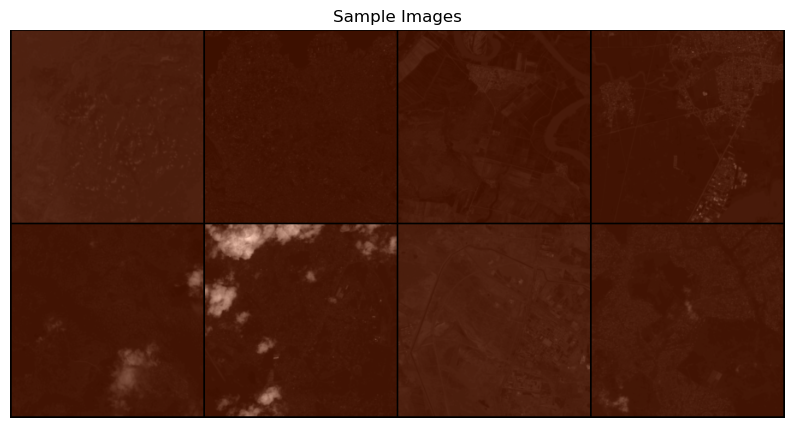

In [14]:
plot_images(train_loader, num_images=8)

In [15]:
class CustomResNet18(nn.Module):
    def __init__(self, num_classes=2):
        super(CustomResNet18, self).__init__()
        self.model = models.resnet18(weights = models.ResNet18_Weights.DEFAULT)

        for param in self.model.parameters():
            param.requires_grad = False
        
        num_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Linear(num_features, num_classes),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

In [16]:
class ResNetBinaryClassifier(pl.LightningModule):
    def __init__(self, num_classes:int, config = None):
        super(ResNetBinaryClassifier, self).__init__()
        self.resnet_model = CustomResNet18(num_classes= 2)
        self.config = config
        
    def forward(self, img_batch):
        return self.resnet_model(img_batch)
    
    def common_step(self, batch):
        x, y = batch
        logits = self.forward (x)

        loss_fn = nn.CrossEntropyLoss()
        loss = loss_fn(logits, y)

        correct = logits.argmax(dim=1).eq(y).sum().item()
        accuracy = self.accuracy(correct, y)

        return loss, accuracy

    def accuracy(self, correct, labels):
        return correct / len(labels)

    def training_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch)
        
        self.log_dict({
            "train_loss": loss,
            "train_accuracy" : accuracy,
        }, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch)

        self.log('val_loss', loss, prog_bar=True)
        self.log('val_accuracy', accuracy, prog_bar=True)

        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        correct = logits.argmax(dim=1).eq(y).sum().items()
        total = len(y)
        accuracy = correct / total

        self.log('test_accuracy', accuracy, prog_bar=True)
        return accuracy


    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr = self.config['lr'])
        return optimizer


In [18]:
config = {
    'lr' : 1e-3
}

In [19]:
def train_resnet(config, num_epochs = 10, checkpoint = None):
    model = ResNetBinaryClassifier(2, config)
    tlogger = TensorBoardLogger(save_dir="flood-logs", name="resnet-model", version = "v1")

    resnet_callbacks = [
        # early_stopping,
        callbacks.ModelCheckpoint(monitor='val_loss', save_top_k=1,
                                  save_on_train_epoch_end= False,
                                  filename='{epoch}-{val_loss:.2f}')
    ]


    trainer = pl.Trainer(accelerator= "gpu",
                         logger= tlogger,
                         log_every_n_steps= 2,
                         precision=16,
                         enable_checkpointing= True,
                         callbacks= resnet_callbacks ,
                         devices= 1,
                         enable_progress_bar= True,
                         max_epochs= num_epochs
                         )
    
    trainer.fit(model, train_dataloaders=train_loader, val_dataloaders= val_loader, ckpt_path = checkpoint)
    return trainer
    

In [21]:
trainer = train_resnet(config= config, num_epochs= 10)

/home/vri/miniconda3/envs/raster_env/lib/python3.11/site-packages/lightning_fabric/connector.py:562: UserWarning: 16 is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
  rank_zero_warn(
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/vri/miniconda3/envs/raster_env/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory flood-logs/resnet-model/v1/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type           | Params
------------------------------------------------
0 | resnet_model | CustomResNet18 | 11.2 M
------------------------------------------------
1.0 K     Trainable params
11.2 M  

Epoch 9: 100%|██████████| 83/83 [00:07<00:00, 10.69it/s, v_num=v1, train_loss=0.313, train_accuracy=1.000, val_loss=0.313, val_accuracy=1.000]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 83/83 [00:07<00:00, 10.69it/s, v_num=v1, train_loss=0.313, train_accuracy=1.000, val_loss=0.313, val_accuracy=1.000]


In [24]:
class CustomExtractor(nn.Module):
    def __init__(self):
        super().__init__()

        self.extractor = models.resnet18(weights = models.ResNet18_Weights.DEFAULT)
        self.extractor = nn.Sequential(*list(self.extractor.children())[:-1])

        for param in self.extractor.parameters():
            param.requires_grad = False

    def forward(self, x):
        return self.extractor(x)
    
extractor = CustomExtractor()


def extract_features(loader: DataLoader):
    feature_list = []
    extractor.eval()

    with torch.no_grad():
        for images, labels in loader:
            features = extractor(images)
            feature_list.append(features)

    return torch.cat(feature_list, dim=0)

In [25]:
train_features = extract_features(train_loader)
val_features = extract_features(val_loader)
test_features = extract_features(test_loader)

In [27]:
train_features.shape

torch.Size([1325, 512, 1, 1])

In [30]:
next(iter(train_loader))[0].shape

torch.Size([16, 3, 224, 224])

In [31]:
def reshape_features(features:Tensor) ->Tensor :
    return features.view(features.size(0), -1)


In [33]:
train_features = reshape_features(train_features)

In [34]:
train_features.shape

torch.Size([1325, 512])

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir="/home/vri/Projects/research/Flood-detection/flood-logs" --host localhost --port 8081

In [23]:
trainer.validate(dataloaders=test_loader, ckpt_path='best')

Restoring states from the checkpoint path at flood-logs/resnet-model/v1/checkpoints/epoch=8-val_loss=0.31-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at flood-logs/resnet-model/v1/checkpoints/epoch=8-val_loss=0.31-v1.ckpt


Validation DataLoader 0: 100%|██████████| 19/19 [00:00<00:00, 42.05it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.validating metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      val_accuracy                  1.0
        val_loss            0.3132625222206116
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.3132625222206116, 'val_accuracy': 1.0}]